# Avellaneda and Stoikov model calibration

AvellanedaStoikov parameter calibration for gamma ray HFT trading bot

In [2]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import math

## Introduction

Gamma ray HFT trading bot uses the finite horizon Avellaneda and Stoikov model with the following formulation:

**assmue order arrial rate**
$$\lambda^a(\delta)=\lambda^b(\delta)=Ae^{-k\delta}$$

**reservation price**

$$r(s,t)=s-q\gamma\sigma^2(T-t)$$

**spread**
$$\delta=\delta^a+\delta^b=\gamma\sigma^2(T-t)+\frac{2}{\gamma}\ln(1+\frac{\gamma}{k})$$

**bid price**
$$r^b(s,q,t)=r(s,t)-\frac{1}{2}\delta$$

**ask price**
$$r^a(s,q,t)=r(s,t)+\frac{1}{2}\delta$$

**The following contents in this notebook will calibrate the following parameters**:

1. sigma
2. k
3. gamma

For more information you can refer to the original [paper](https://www.researchgate.net/publication/24086205_High_Frequency_Trading_in_a_Limit_Order_Book). It is worth noting that calibration of the above parameters are non-trivial, they are active research fields with various on going studies. This notebook only provide one (simple) method for calibrating the model.

## Playground

This is a implementation of the model in python, you can plug in different parameters and see the outputs of the model to get a tangible feeling of the model

In [3]:
T = 1.0
t = 0.0
dt = T - t
gamma = 0.1
sigma = 0.02
k = 0.1159
q = 0
s = 9500

r = s - q * gamma * sigma**2 * dt

# Reserve spread
r_spread = gamma * sigma**2 * dt +2 / gamma * math.log(1+gamma/k)

# optimal quotes
ra = r + r_spread/2
rb = r - r_spread/2
print("ask quote: ", ra)
print("bid quote", rb)

ask quote:  9506.220895871751
bid quote 9493.779104128249


## Trading data

For illustration purpose, we will only one day's XBTUSD quoting data and trading data. In practise you should use a much longer sample of historical prices and trades. You can get all historical data here: https://public.bitmex.com/

In [ ]:
quotes = pd.read_csv("./data/XBTUSD_quote.csv")
trades = pd.read_csv("./data/XBTUSD_trade.csv")
quotes.loc[:, 'timestamp'] = pd.to_datetime(quotes.timestamp, format="%Y-%m-%dD%H:%M:%S.%f")
trades.loc[:, 'timestamp'] = pd.to_datetime(trades.timestamp, format="%Y-%m-%dD%H:%M:%S.%f")

In [11]:
# calculate mid price by averaging best bid and best ask
# print(quotes.bidPrice + quotes.askPrice)
quotes.loc[:, 'midPrice'] = (quotes.bidPrice + quotes.askPrice) / 2

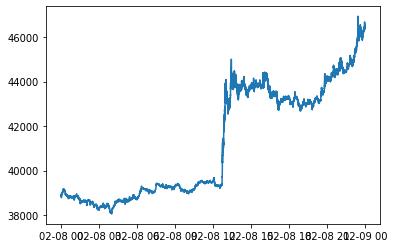

In [12]:
# reset the index to timestamp and plot the price change for the day
Xt = quotes.set_index('timestamp').midPrice
plt.plot(Xt)

## Parameter estimation: sigma

In this chapter we calibrate the model parameter sigma, which is measures the volitility of an assumed brownian motion. We use the first solution proposed here:
https://alexioannides.com/2019/01/18/stochastic-process-calibration-using-bayesian-inference-probabilistic-programs/

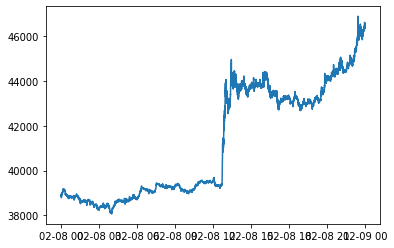

In [13]:
# resample prices with 1 second fixed interval
resample = Xt.resample('1S').last().bfill()
plt.plot(resample)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='midPrice', ylabel='Density'>

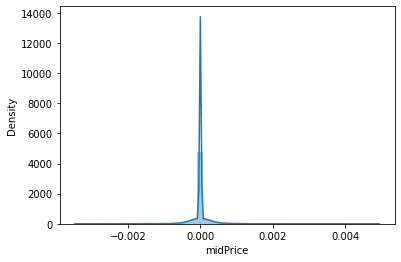

In [14]:
log_norm = np.log(resample).diff(1).dropna()
sns.distplot(log_norm)

In [15]:
# calculate deviation
sigma = log_norm.std() * np.sqrt(3600*24)
print(sigma)

0.06189521955218768


## Parameter esitmation: k

Parameter k measures the probability of an order being executed at a given tick, here will estimate k by counting trades in **n** samples with each sample being a 10 seconds time period. For more information you can read Joaquin FERNANDEZ TAPIA's PhD thesis:
[Modeling, optimization and estimation for the on-line control of trading algorithms in limit-order markets](https://www.researchgate.net/publication/284900784_Modeling_optimization_and_estimation_for_the_on-line_control_of_trading_algorithms_in_limit-order_markets) Chapter 4

![captured liquidity](./footage/captured_liquidity.png)

### Average volume quantity

We will find the average marketable order size

In [16]:
# we use the median quantity as the average volume quantity
trades_filtered = trades[trades['size'] > 25] # filter out small trades
trades_filtered['size'].describe()

count    4.061300e+05
mean     1.151581e+04
std      3.964582e+04
min      2.600000e+01
25%      4.600000e+02
50%      2.000000e+03
75%      1.000000e+04
max      4.374338e+06
Name: size, dtype: float64

So the average volume quantity is 50 percentile: 500

### Estimate trade intensity

In [17]:
# rounding util functions

def round_up(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return x + tick - remainder

def round_down(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return math.floor(x / tick) * tick

In [18]:
# TODO: this part is really slow, could be more efficient(pre-allocate memory) and use parallel processing to speed things up

# sample time window in seconds
dT = 10
# number of samples
n = 0
# initial timestamp
T0 = quotes.iloc[0, :].timestamp
# end timestamp
T_final = quotes.iloc[-1, :].timestamp
# min tick size
tick = 0.5
# measured spread range
r = 40 # 40*0.5=20

T_start = T0
T_end = T_start + pd.Timedelta(seconds=dT)

ask_side_hits = np.array([])
bid_side_hits = np.array([])

while T_end < T_final:

    print("Processing timestamp: ", T_start)
    # reference price S(t)
    St = quotes[quotes.timestamp >= T_start].iloc[0, :].midPrice
    # ask side
    St_ask = round_down(St, tick)
    # get marketable bids
    criteria_1 = (trades_filtered.timestamp >= T_start) # timestamp later than T_start
    criteria_2 = (trades_filtered.timestamp < T_end) # timestamp ealier than T_end
    criteria_3 = (trades_filtered.side == 'Buy') # side is "Buy"
    criteria_4 = (trades_filtered.price > St_ask) # price must be higher than St_ask
    criteria_5 = (trades_filtered.price <= St_ask + (r * tick)) # price must be lower than the measured spread range
    m_bids = trades_filtered[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]

    if len(m_bids.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_bids.price.unique(), St_ask), tick)
        ask_side_hits = np.hstack([ask_side_hits, hits])

    # bid side
    St_bid = round_up(St, tick)
    # get marketable asks
    criteria_1 = (trades_filtered.timestamp >= T_start) # timestamp later than T_start
    criteria_2 = (trades_filtered.timestamp < T_end) # timestamp ealier than T_end
    criteria_3 = (trades_filtered.side == 'Sell') # side is "Sell"
    criteria_4 = (trades_filtered.price < St_bid) # price must be lower than St_bid
    criteria_5 = (trades_filtered.price >= St_bid - (r * tick)) # price must be higher than the measured spread range
    m_asks = trades_filtered[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]

    if len(m_asks.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_asks.price.unique(), St_bid), -tick)
        bid_side_hits = np.hstack([bid_side_hits, hits])

    T_start = T_start + pd.Timedelta(seconds=dT)
    T_end = T_end + pd.Timedelta(seconds=dT)
    n = n + 1
    # break

print('done with {0} samples'.format(n))

Processing timestamp:  2021-02-08 00:00:00.991963
Processing timestamp:  2021-02-08 00:00:10.991963
Processing timestamp:  2021-02-08 00:00:20.991963
Processing timestamp:  2021-02-08 00:00:30.991963
Processing timestamp:  2021-02-08 00:00:40.991963
Processing timestamp:  2021-02-08 00:00:50.991963
Processing timestamp:  2021-02-08 00:01:00.991963
Processing timestamp:  2021-02-08 00:01:10.991963
Processing timestamp:  2021-02-08 00:01:20.991963
Processing timestamp:  2021-02-08 00:01:30.991963
Processing timestamp:  2021-02-08 00:01:40.991963
Processing timestamp:  2021-02-08 00:01:50.991963
Processing timestamp:  2021-02-08 00:02:00.991963
Processing timestamp:  2021-02-08 00:02:10.991963
Processing timestamp:  2021-02-08 00:02:20.991963
Processing timestamp:  2021-02-08 00:02:30.991963
Processing timestamp:  2021-02-08 00:02:40.991963
Processing timestamp:  2021-02-08 00:02:50.991963
Processing timestamp:  2021-02-08 00:03:00.991963
Processing timestamp:  2021-02-08 00:03:10.991963


Processing timestamp:  2021-02-08 00:27:30.991963
Processing timestamp:  2021-02-08 00:27:40.991963
Processing timestamp:  2021-02-08 00:27:50.991963
Processing timestamp:  2021-02-08 00:28:00.991963
Processing timestamp:  2021-02-08 00:28:10.991963
Processing timestamp:  2021-02-08 00:28:20.991963
Processing timestamp:  2021-02-08 00:28:30.991963
Processing timestamp:  2021-02-08 00:28:40.991963
Processing timestamp:  2021-02-08 00:28:50.991963
Processing timestamp:  2021-02-08 00:29:00.991963
Processing timestamp:  2021-02-08 00:29:10.991963
Processing timestamp:  2021-02-08 00:29:20.991963
Processing timestamp:  2021-02-08 00:29:30.991963
Processing timestamp:  2021-02-08 00:29:40.991963
Processing timestamp:  2021-02-08 00:29:50.991963
Processing timestamp:  2021-02-08 00:30:00.991963
Processing timestamp:  2021-02-08 00:30:10.991963
Processing timestamp:  2021-02-08 00:30:20.991963
Processing timestamp:  2021-02-08 00:30:30.991963
Processing timestamp:  2021-02-08 00:30:40.991963


Processing timestamp:  2021-02-08 00:54:50.991963
Processing timestamp:  2021-02-08 00:55:00.991963
Processing timestamp:  2021-02-08 00:55:10.991963
Processing timestamp:  2021-02-08 00:55:20.991963
Processing timestamp:  2021-02-08 00:55:30.991963
Processing timestamp:  2021-02-08 00:55:40.991963
Processing timestamp:  2021-02-08 00:55:50.991963
Processing timestamp:  2021-02-08 00:56:00.991963
Processing timestamp:  2021-02-08 00:56:10.991963
Processing timestamp:  2021-02-08 00:56:20.991963
Processing timestamp:  2021-02-08 00:56:30.991963
Processing timestamp:  2021-02-08 00:56:40.991963
Processing timestamp:  2021-02-08 00:56:50.991963
Processing timestamp:  2021-02-08 00:57:00.991963
Processing timestamp:  2021-02-08 00:57:10.991963
Processing timestamp:  2021-02-08 00:57:20.991963
Processing timestamp:  2021-02-08 00:57:30.991963
Processing timestamp:  2021-02-08 00:57:40.991963
Processing timestamp:  2021-02-08 00:57:50.991963
Processing timestamp:  2021-02-08 00:58:00.991963


Processing timestamp:  2021-02-08 01:22:10.991963
Processing timestamp:  2021-02-08 01:22:20.991963
Processing timestamp:  2021-02-08 01:22:30.991963
Processing timestamp:  2021-02-08 01:22:40.991963
Processing timestamp:  2021-02-08 01:22:50.991963
Processing timestamp:  2021-02-08 01:23:00.991963
Processing timestamp:  2021-02-08 01:23:10.991963
Processing timestamp:  2021-02-08 01:23:20.991963
Processing timestamp:  2021-02-08 01:23:30.991963
Processing timestamp:  2021-02-08 01:23:40.991963
Processing timestamp:  2021-02-08 01:23:50.991963
Processing timestamp:  2021-02-08 01:24:00.991963
Processing timestamp:  2021-02-08 01:24:10.991963
Processing timestamp:  2021-02-08 01:24:20.991963
Processing timestamp:  2021-02-08 01:24:30.991963
Processing timestamp:  2021-02-08 01:24:40.991963
Processing timestamp:  2021-02-08 01:24:50.991963
Processing timestamp:  2021-02-08 01:25:00.991963
Processing timestamp:  2021-02-08 01:25:10.991963
Processing timestamp:  2021-02-08 01:25:20.991963


Processing timestamp:  2021-02-08 01:49:30.991963
Processing timestamp:  2021-02-08 01:49:40.991963
Processing timestamp:  2021-02-08 01:49:50.991963
Processing timestamp:  2021-02-08 01:50:00.991963
Processing timestamp:  2021-02-08 01:50:10.991963
Processing timestamp:  2021-02-08 01:50:20.991963
Processing timestamp:  2021-02-08 01:50:30.991963
Processing timestamp:  2021-02-08 01:50:40.991963
Processing timestamp:  2021-02-08 01:50:50.991963
Processing timestamp:  2021-02-08 01:51:00.991963
Processing timestamp:  2021-02-08 01:51:10.991963
Processing timestamp:  2021-02-08 01:51:20.991963
Processing timestamp:  2021-02-08 01:51:30.991963
Processing timestamp:  2021-02-08 01:51:40.991963
Processing timestamp:  2021-02-08 01:51:50.991963
Processing timestamp:  2021-02-08 01:52:00.991963
Processing timestamp:  2021-02-08 01:52:10.991963
Processing timestamp:  2021-02-08 01:52:20.991963
Processing timestamp:  2021-02-08 01:52:30.991963
Processing timestamp:  2021-02-08 01:52:40.991963


Processing timestamp:  2021-02-08 02:16:50.991963
Processing timestamp:  2021-02-08 02:17:00.991963
Processing timestamp:  2021-02-08 02:17:10.991963
Processing timestamp:  2021-02-08 02:17:20.991963
Processing timestamp:  2021-02-08 02:17:30.991963
Processing timestamp:  2021-02-08 02:17:40.991963
Processing timestamp:  2021-02-08 02:17:50.991963
Processing timestamp:  2021-02-08 02:18:00.991963
Processing timestamp:  2021-02-08 02:18:10.991963
Processing timestamp:  2021-02-08 02:18:20.991963
Processing timestamp:  2021-02-08 02:18:30.991963
Processing timestamp:  2021-02-08 02:18:40.991963
Processing timestamp:  2021-02-08 02:18:50.991963
Processing timestamp:  2021-02-08 02:19:00.991963
Processing timestamp:  2021-02-08 02:19:10.991963
Processing timestamp:  2021-02-08 02:19:20.991963
Processing timestamp:  2021-02-08 02:19:30.991963
Processing timestamp:  2021-02-08 02:19:40.991963
Processing timestamp:  2021-02-08 02:19:50.991963
Processing timestamp:  2021-02-08 02:20:00.991963


Processing timestamp:  2021-02-08 02:44:20.991963
Processing timestamp:  2021-02-08 02:44:30.991963
Processing timestamp:  2021-02-08 02:44:40.991963
Processing timestamp:  2021-02-08 02:44:50.991963
Processing timestamp:  2021-02-08 02:45:00.991963
Processing timestamp:  2021-02-08 02:45:10.991963
Processing timestamp:  2021-02-08 02:45:20.991963
Processing timestamp:  2021-02-08 02:45:30.991963
Processing timestamp:  2021-02-08 02:45:40.991963
Processing timestamp:  2021-02-08 02:45:50.991963
Processing timestamp:  2021-02-08 02:46:00.991963
Processing timestamp:  2021-02-08 02:46:10.991963
Processing timestamp:  2021-02-08 02:46:20.991963
Processing timestamp:  2021-02-08 02:46:30.991963
Processing timestamp:  2021-02-08 02:46:40.991963
Processing timestamp:  2021-02-08 02:46:50.991963
Processing timestamp:  2021-02-08 02:47:00.991963
Processing timestamp:  2021-02-08 02:47:10.991963
Processing timestamp:  2021-02-08 02:47:20.991963
Processing timestamp:  2021-02-08 02:47:30.991963


Processing timestamp:  2021-02-08 03:11:40.991963
Processing timestamp:  2021-02-08 03:11:50.991963
Processing timestamp:  2021-02-08 03:12:00.991963
Processing timestamp:  2021-02-08 03:12:10.991963
Processing timestamp:  2021-02-08 03:12:20.991963
Processing timestamp:  2021-02-08 03:12:30.991963
Processing timestamp:  2021-02-08 03:12:40.991963
Processing timestamp:  2021-02-08 03:12:50.991963
Processing timestamp:  2021-02-08 03:13:00.991963
Processing timestamp:  2021-02-08 03:13:10.991963
Processing timestamp:  2021-02-08 03:13:20.991963
Processing timestamp:  2021-02-08 03:13:30.991963
Processing timestamp:  2021-02-08 03:13:40.991963
Processing timestamp:  2021-02-08 03:13:50.991963
Processing timestamp:  2021-02-08 03:14:00.991963
Processing timestamp:  2021-02-08 03:14:10.991963
Processing timestamp:  2021-02-08 03:14:20.991963
Processing timestamp:  2021-02-08 03:14:30.991963
Processing timestamp:  2021-02-08 03:14:40.991963
Processing timestamp:  2021-02-08 03:14:50.991963


Processing timestamp:  2021-02-08 03:39:00.991963
Processing timestamp:  2021-02-08 03:39:10.991963
Processing timestamp:  2021-02-08 03:39:20.991963
Processing timestamp:  2021-02-08 03:39:30.991963
Processing timestamp:  2021-02-08 03:39:40.991963
Processing timestamp:  2021-02-08 03:39:50.991963
Processing timestamp:  2021-02-08 03:40:00.991963
Processing timestamp:  2021-02-08 03:40:10.991963
Processing timestamp:  2021-02-08 03:40:20.991963
Processing timestamp:  2021-02-08 03:40:30.991963
Processing timestamp:  2021-02-08 03:40:40.991963
Processing timestamp:  2021-02-08 03:40:50.991963
Processing timestamp:  2021-02-08 03:41:00.991963
Processing timestamp:  2021-02-08 03:41:10.991963
Processing timestamp:  2021-02-08 03:41:20.991963
Processing timestamp:  2021-02-08 03:41:30.991963
Processing timestamp:  2021-02-08 03:41:40.991963
Processing timestamp:  2021-02-08 03:41:50.991963
Processing timestamp:  2021-02-08 03:42:00.991963
Processing timestamp:  2021-02-08 03:42:10.991963


Processing timestamp:  2021-02-08 04:06:20.991963
Processing timestamp:  2021-02-08 04:06:30.991963
Processing timestamp:  2021-02-08 04:06:40.991963
Processing timestamp:  2021-02-08 04:06:50.991963
Processing timestamp:  2021-02-08 04:07:00.991963
Processing timestamp:  2021-02-08 04:07:10.991963
Processing timestamp:  2021-02-08 04:07:20.991963
Processing timestamp:  2021-02-08 04:07:30.991963
Processing timestamp:  2021-02-08 04:07:40.991963
Processing timestamp:  2021-02-08 04:07:50.991963
Processing timestamp:  2021-02-08 04:08:00.991963
Processing timestamp:  2021-02-08 04:08:10.991963
Processing timestamp:  2021-02-08 04:08:20.991963
Processing timestamp:  2021-02-08 04:08:30.991963
Processing timestamp:  2021-02-08 04:08:40.991963
Processing timestamp:  2021-02-08 04:08:50.991963
Processing timestamp:  2021-02-08 04:09:00.991963
Processing timestamp:  2021-02-08 04:09:10.991963
Processing timestamp:  2021-02-08 04:09:20.991963
Processing timestamp:  2021-02-08 04:09:30.991963


Processing timestamp:  2021-02-08 04:33:40.991963
Processing timestamp:  2021-02-08 04:33:50.991963
Processing timestamp:  2021-02-08 04:34:00.991963
Processing timestamp:  2021-02-08 04:34:10.991963
Processing timestamp:  2021-02-08 04:34:20.991963
Processing timestamp:  2021-02-08 04:34:30.991963
Processing timestamp:  2021-02-08 04:34:40.991963
Processing timestamp:  2021-02-08 04:34:50.991963
Processing timestamp:  2021-02-08 04:35:00.991963
Processing timestamp:  2021-02-08 04:35:10.991963
Processing timestamp:  2021-02-08 04:35:20.991963
Processing timestamp:  2021-02-08 04:35:30.991963
Processing timestamp:  2021-02-08 04:35:40.991963
Processing timestamp:  2021-02-08 04:35:50.991963
Processing timestamp:  2021-02-08 04:36:00.991963
Processing timestamp:  2021-02-08 04:36:10.991963
Processing timestamp:  2021-02-08 04:36:20.991963
Processing timestamp:  2021-02-08 04:36:30.991963
Processing timestamp:  2021-02-08 04:36:40.991963
Processing timestamp:  2021-02-08 04:36:50.991963


Processing timestamp:  2021-02-08 05:01:00.991963
Processing timestamp:  2021-02-08 05:01:10.991963
Processing timestamp:  2021-02-08 05:01:20.991963
Processing timestamp:  2021-02-08 05:01:30.991963
Processing timestamp:  2021-02-08 05:01:40.991963
Processing timestamp:  2021-02-08 05:01:50.991963
Processing timestamp:  2021-02-08 05:02:00.991963
Processing timestamp:  2021-02-08 05:02:10.991963
Processing timestamp:  2021-02-08 05:02:20.991963
Processing timestamp:  2021-02-08 05:02:30.991963
Processing timestamp:  2021-02-08 05:02:40.991963
Processing timestamp:  2021-02-08 05:02:50.991963
Processing timestamp:  2021-02-08 05:03:00.991963
Processing timestamp:  2021-02-08 05:03:10.991963
Processing timestamp:  2021-02-08 05:03:20.991963
Processing timestamp:  2021-02-08 05:03:30.991963
Processing timestamp:  2021-02-08 05:03:40.991963
Processing timestamp:  2021-02-08 05:03:50.991963
Processing timestamp:  2021-02-08 05:04:00.991963
Processing timestamp:  2021-02-08 05:04:10.991963


Processing timestamp:  2021-02-08 05:28:20.991963
Processing timestamp:  2021-02-08 05:28:30.991963
Processing timestamp:  2021-02-08 05:28:40.991963
Processing timestamp:  2021-02-08 05:28:50.991963
Processing timestamp:  2021-02-08 05:29:00.991963
Processing timestamp:  2021-02-08 05:29:10.991963
Processing timestamp:  2021-02-08 05:29:20.991963
Processing timestamp:  2021-02-08 05:29:30.991963
Processing timestamp:  2021-02-08 05:29:40.991963
Processing timestamp:  2021-02-08 05:29:50.991963
Processing timestamp:  2021-02-08 05:30:00.991963
Processing timestamp:  2021-02-08 05:30:10.991963
Processing timestamp:  2021-02-08 05:30:20.991963
Processing timestamp:  2021-02-08 05:30:30.991963
Processing timestamp:  2021-02-08 05:30:40.991963
Processing timestamp:  2021-02-08 05:30:50.991963
Processing timestamp:  2021-02-08 05:31:00.991963
Processing timestamp:  2021-02-08 05:31:10.991963
Processing timestamp:  2021-02-08 05:31:20.991963
Processing timestamp:  2021-02-08 05:31:30.991963


Processing timestamp:  2021-02-08 05:55:40.991963
Processing timestamp:  2021-02-08 05:55:50.991963
Processing timestamp:  2021-02-08 05:56:00.991963
Processing timestamp:  2021-02-08 05:56:10.991963
Processing timestamp:  2021-02-08 05:56:20.991963
Processing timestamp:  2021-02-08 05:56:30.991963
Processing timestamp:  2021-02-08 05:56:40.991963
Processing timestamp:  2021-02-08 05:56:50.991963
Processing timestamp:  2021-02-08 05:57:00.991963
Processing timestamp:  2021-02-08 05:57:10.991963
Processing timestamp:  2021-02-08 05:57:20.991963
Processing timestamp:  2021-02-08 05:57:30.991963
Processing timestamp:  2021-02-08 05:57:40.991963
Processing timestamp:  2021-02-08 05:57:50.991963
Processing timestamp:  2021-02-08 05:58:00.991963
Processing timestamp:  2021-02-08 05:58:10.991963
Processing timestamp:  2021-02-08 05:58:20.991963
Processing timestamp:  2021-02-08 05:58:30.991963
Processing timestamp:  2021-02-08 05:58:40.991963
Processing timestamp:  2021-02-08 05:58:50.991963


Processing timestamp:  2021-02-08 06:23:00.991963
Processing timestamp:  2021-02-08 06:23:10.991963
Processing timestamp:  2021-02-08 06:23:20.991963
Processing timestamp:  2021-02-08 06:23:30.991963
Processing timestamp:  2021-02-08 06:23:40.991963
Processing timestamp:  2021-02-08 06:23:50.991963
Processing timestamp:  2021-02-08 06:24:00.991963
Processing timestamp:  2021-02-08 06:24:10.991963
Processing timestamp:  2021-02-08 06:24:20.991963
Processing timestamp:  2021-02-08 06:24:30.991963
Processing timestamp:  2021-02-08 06:24:40.991963
Processing timestamp:  2021-02-08 06:24:50.991963
Processing timestamp:  2021-02-08 06:25:00.991963
Processing timestamp:  2021-02-08 06:25:10.991963
Processing timestamp:  2021-02-08 06:25:20.991963
Processing timestamp:  2021-02-08 06:25:30.991963
Processing timestamp:  2021-02-08 06:25:40.991963
Processing timestamp:  2021-02-08 06:25:50.991963
Processing timestamp:  2021-02-08 06:26:00.991963
Processing timestamp:  2021-02-08 06:26:10.991963


Processing timestamp:  2021-02-08 06:50:20.991963
Processing timestamp:  2021-02-08 06:50:30.991963
Processing timestamp:  2021-02-08 06:50:40.991963
Processing timestamp:  2021-02-08 06:50:50.991963
Processing timestamp:  2021-02-08 06:51:00.991963
Processing timestamp:  2021-02-08 06:51:10.991963
Processing timestamp:  2021-02-08 06:51:20.991963
Processing timestamp:  2021-02-08 06:51:30.991963
Processing timestamp:  2021-02-08 06:51:40.991963
Processing timestamp:  2021-02-08 06:51:50.991963
Processing timestamp:  2021-02-08 06:52:00.991963
Processing timestamp:  2021-02-08 06:52:10.991963
Processing timestamp:  2021-02-08 06:52:20.991963
Processing timestamp:  2021-02-08 06:52:30.991963
Processing timestamp:  2021-02-08 06:52:40.991963
Processing timestamp:  2021-02-08 06:52:50.991963
Processing timestamp:  2021-02-08 06:53:00.991963
Processing timestamp:  2021-02-08 06:53:10.991963
Processing timestamp:  2021-02-08 06:53:20.991963
Processing timestamp:  2021-02-08 06:53:30.991963


Processing timestamp:  2021-02-08 07:17:40.991963
Processing timestamp:  2021-02-08 07:17:50.991963
Processing timestamp:  2021-02-08 07:18:00.991963
Processing timestamp:  2021-02-08 07:18:10.991963
Processing timestamp:  2021-02-08 07:18:20.991963
Processing timestamp:  2021-02-08 07:18:30.991963
Processing timestamp:  2021-02-08 07:18:40.991963
Processing timestamp:  2021-02-08 07:18:50.991963
Processing timestamp:  2021-02-08 07:19:00.991963
Processing timestamp:  2021-02-08 07:19:10.991963
Processing timestamp:  2021-02-08 07:19:20.991963
Processing timestamp:  2021-02-08 07:19:30.991963
Processing timestamp:  2021-02-08 07:19:40.991963
Processing timestamp:  2021-02-08 07:19:50.991963
Processing timestamp:  2021-02-08 07:20:00.991963
Processing timestamp:  2021-02-08 07:20:10.991963
Processing timestamp:  2021-02-08 07:20:20.991963
Processing timestamp:  2021-02-08 07:20:30.991963
Processing timestamp:  2021-02-08 07:20:40.991963
Processing timestamp:  2021-02-08 07:20:50.991963


Processing timestamp:  2021-02-08 07:45:10.991963
Processing timestamp:  2021-02-08 07:45:20.991963
Processing timestamp:  2021-02-08 07:45:30.991963
Processing timestamp:  2021-02-08 07:45:40.991963
Processing timestamp:  2021-02-08 07:45:50.991963
Processing timestamp:  2021-02-08 07:46:00.991963
Processing timestamp:  2021-02-08 07:46:10.991963
Processing timestamp:  2021-02-08 07:46:20.991963
Processing timestamp:  2021-02-08 07:46:30.991963
Processing timestamp:  2021-02-08 07:46:40.991963
Processing timestamp:  2021-02-08 07:46:50.991963
Processing timestamp:  2021-02-08 07:47:00.991963
Processing timestamp:  2021-02-08 07:47:10.991963
Processing timestamp:  2021-02-08 07:47:20.991963
Processing timestamp:  2021-02-08 07:47:30.991963
Processing timestamp:  2021-02-08 07:47:40.991963
Processing timestamp:  2021-02-08 07:47:50.991963
Processing timestamp:  2021-02-08 07:48:00.991963
Processing timestamp:  2021-02-08 07:48:10.991963
Processing timestamp:  2021-02-08 07:48:20.991963


Processing timestamp:  2021-02-08 08:12:30.991963
Processing timestamp:  2021-02-08 08:12:40.991963
Processing timestamp:  2021-02-08 08:12:50.991963
Processing timestamp:  2021-02-08 08:13:00.991963
Processing timestamp:  2021-02-08 08:13:10.991963
Processing timestamp:  2021-02-08 08:13:20.991963
Processing timestamp:  2021-02-08 08:13:30.991963
Processing timestamp:  2021-02-08 08:13:40.991963
Processing timestamp:  2021-02-08 08:13:50.991963
Processing timestamp:  2021-02-08 08:14:00.991963
Processing timestamp:  2021-02-08 08:14:10.991963
Processing timestamp:  2021-02-08 08:14:20.991963
Processing timestamp:  2021-02-08 08:14:30.991963
Processing timestamp:  2021-02-08 08:14:40.991963
Processing timestamp:  2021-02-08 08:14:50.991963
Processing timestamp:  2021-02-08 08:15:00.991963
Processing timestamp:  2021-02-08 08:15:10.991963
Processing timestamp:  2021-02-08 08:15:20.991963
Processing timestamp:  2021-02-08 08:15:30.991963
Processing timestamp:  2021-02-08 08:15:40.991963


Processing timestamp:  2021-02-08 08:39:50.991963
Processing timestamp:  2021-02-08 08:40:00.991963
Processing timestamp:  2021-02-08 08:40:10.991963
Processing timestamp:  2021-02-08 08:40:20.991963
Processing timestamp:  2021-02-08 08:40:30.991963
Processing timestamp:  2021-02-08 08:40:40.991963
Processing timestamp:  2021-02-08 08:40:50.991963
Processing timestamp:  2021-02-08 08:41:00.991963
Processing timestamp:  2021-02-08 08:41:10.991963
Processing timestamp:  2021-02-08 08:41:20.991963
Processing timestamp:  2021-02-08 08:41:30.991963
Processing timestamp:  2021-02-08 08:41:40.991963
Processing timestamp:  2021-02-08 08:41:50.991963
Processing timestamp:  2021-02-08 08:42:00.991963
Processing timestamp:  2021-02-08 08:42:10.991963
Processing timestamp:  2021-02-08 08:42:20.991963
Processing timestamp:  2021-02-08 08:42:30.991963
Processing timestamp:  2021-02-08 08:42:40.991963
Processing timestamp:  2021-02-08 08:42:50.991963
Processing timestamp:  2021-02-08 08:43:00.991963


Processing timestamp:  2021-02-08 09:07:20.991963
Processing timestamp:  2021-02-08 09:07:30.991963
Processing timestamp:  2021-02-08 09:07:40.991963
Processing timestamp:  2021-02-08 09:07:50.991963
Processing timestamp:  2021-02-08 09:08:00.991963
Processing timestamp:  2021-02-08 09:08:10.991963
Processing timestamp:  2021-02-08 09:08:20.991963
Processing timestamp:  2021-02-08 09:08:30.991963
Processing timestamp:  2021-02-08 09:08:40.991963
Processing timestamp:  2021-02-08 09:08:50.991963
Processing timestamp:  2021-02-08 09:09:00.991963
Processing timestamp:  2021-02-08 09:09:10.991963
Processing timestamp:  2021-02-08 09:09:20.991963
Processing timestamp:  2021-02-08 09:09:30.991963
Processing timestamp:  2021-02-08 09:09:40.991963
Processing timestamp:  2021-02-08 09:09:50.991963
Processing timestamp:  2021-02-08 09:10:00.991963
Processing timestamp:  2021-02-08 09:10:10.991963
Processing timestamp:  2021-02-08 09:10:20.991963
Processing timestamp:  2021-02-08 09:10:30.991963


Processing timestamp:  2021-02-08 09:34:40.991963
Processing timestamp:  2021-02-08 09:34:50.991963
Processing timestamp:  2021-02-08 09:35:00.991963
Processing timestamp:  2021-02-08 09:35:10.991963
Processing timestamp:  2021-02-08 09:35:20.991963
Processing timestamp:  2021-02-08 09:35:30.991963
Processing timestamp:  2021-02-08 09:35:40.991963
Processing timestamp:  2021-02-08 09:35:50.991963
Processing timestamp:  2021-02-08 09:36:00.991963
Processing timestamp:  2021-02-08 09:36:10.991963
Processing timestamp:  2021-02-08 09:36:20.991963
Processing timestamp:  2021-02-08 09:36:30.991963
Processing timestamp:  2021-02-08 09:36:40.991963
Processing timestamp:  2021-02-08 09:36:50.991963
Processing timestamp:  2021-02-08 09:37:00.991963
Processing timestamp:  2021-02-08 09:37:10.991963
Processing timestamp:  2021-02-08 09:37:20.991963
Processing timestamp:  2021-02-08 09:37:30.991963
Processing timestamp:  2021-02-08 09:37:40.991963
Processing timestamp:  2021-02-08 09:37:50.991963


Processing timestamp:  2021-02-08 10:02:00.991963
Processing timestamp:  2021-02-08 10:02:10.991963
Processing timestamp:  2021-02-08 10:02:20.991963
Processing timestamp:  2021-02-08 10:02:30.991963
Processing timestamp:  2021-02-08 10:02:40.991963
Processing timestamp:  2021-02-08 10:02:50.991963
Processing timestamp:  2021-02-08 10:03:00.991963
Processing timestamp:  2021-02-08 10:03:10.991963
Processing timestamp:  2021-02-08 10:03:20.991963
Processing timestamp:  2021-02-08 10:03:30.991963
Processing timestamp:  2021-02-08 10:03:40.991963
Processing timestamp:  2021-02-08 10:03:50.991963
Processing timestamp:  2021-02-08 10:04:00.991963
Processing timestamp:  2021-02-08 10:04:10.991963
Processing timestamp:  2021-02-08 10:04:20.991963
Processing timestamp:  2021-02-08 10:04:30.991963
Processing timestamp:  2021-02-08 10:04:40.991963
Processing timestamp:  2021-02-08 10:04:50.991963
Processing timestamp:  2021-02-08 10:05:00.991963
Processing timestamp:  2021-02-08 10:05:10.991963


Processing timestamp:  2021-02-08 10:29:20.991963
Processing timestamp:  2021-02-08 10:29:30.991963
Processing timestamp:  2021-02-08 10:29:40.991963
Processing timestamp:  2021-02-08 10:29:50.991963
Processing timestamp:  2021-02-08 10:30:00.991963
Processing timestamp:  2021-02-08 10:30:10.991963
Processing timestamp:  2021-02-08 10:30:20.991963
Processing timestamp:  2021-02-08 10:30:30.991963
Processing timestamp:  2021-02-08 10:30:40.991963
Processing timestamp:  2021-02-08 10:30:50.991963
Processing timestamp:  2021-02-08 10:31:00.991963
Processing timestamp:  2021-02-08 10:31:10.991963
Processing timestamp:  2021-02-08 10:31:20.991963
Processing timestamp:  2021-02-08 10:31:30.991963
Processing timestamp:  2021-02-08 10:31:40.991963
Processing timestamp:  2021-02-08 10:31:50.991963
Processing timestamp:  2021-02-08 10:32:00.991963
Processing timestamp:  2021-02-08 10:32:10.991963
Processing timestamp:  2021-02-08 10:32:20.991963
Processing timestamp:  2021-02-08 10:32:30.991963


Processing timestamp:  2021-02-08 10:56:50.991963
Processing timestamp:  2021-02-08 10:57:00.991963
Processing timestamp:  2021-02-08 10:57:10.991963
Processing timestamp:  2021-02-08 10:57:20.991963
Processing timestamp:  2021-02-08 10:57:30.991963
Processing timestamp:  2021-02-08 10:57:40.991963
Processing timestamp:  2021-02-08 10:57:50.991963
Processing timestamp:  2021-02-08 10:58:00.991963
Processing timestamp:  2021-02-08 10:58:10.991963
Processing timestamp:  2021-02-08 10:58:20.991963
Processing timestamp:  2021-02-08 10:58:30.991963
Processing timestamp:  2021-02-08 10:58:40.991963
Processing timestamp:  2021-02-08 10:58:50.991963
Processing timestamp:  2021-02-08 10:59:00.991963
Processing timestamp:  2021-02-08 10:59:10.991963
Processing timestamp:  2021-02-08 10:59:20.991963
Processing timestamp:  2021-02-08 10:59:30.991963
Processing timestamp:  2021-02-08 10:59:40.991963
Processing timestamp:  2021-02-08 10:59:50.991963
Processing timestamp:  2021-02-08 11:00:00.991963


Processing timestamp:  2021-02-08 11:24:10.991963
Processing timestamp:  2021-02-08 11:24:20.991963
Processing timestamp:  2021-02-08 11:24:30.991963
Processing timestamp:  2021-02-08 11:24:40.991963
Processing timestamp:  2021-02-08 11:24:50.991963
Processing timestamp:  2021-02-08 11:25:00.991963
Processing timestamp:  2021-02-08 11:25:10.991963
Processing timestamp:  2021-02-08 11:25:20.991963
Processing timestamp:  2021-02-08 11:25:30.991963
Processing timestamp:  2021-02-08 11:25:40.991963
Processing timestamp:  2021-02-08 11:25:50.991963
Processing timestamp:  2021-02-08 11:26:00.991963
Processing timestamp:  2021-02-08 11:26:10.991963
Processing timestamp:  2021-02-08 11:26:20.991963
Processing timestamp:  2021-02-08 11:26:30.991963
Processing timestamp:  2021-02-08 11:26:40.991963
Processing timestamp:  2021-02-08 11:26:50.991963
Processing timestamp:  2021-02-08 11:27:00.991963
Processing timestamp:  2021-02-08 11:27:10.991963
Processing timestamp:  2021-02-08 11:27:20.991963


Processing timestamp:  2021-02-08 11:51:30.991963
Processing timestamp:  2021-02-08 11:51:40.991963
Processing timestamp:  2021-02-08 11:51:50.991963
Processing timestamp:  2021-02-08 11:52:00.991963
Processing timestamp:  2021-02-08 11:52:10.991963
Processing timestamp:  2021-02-08 11:52:20.991963
Processing timestamp:  2021-02-08 11:52:30.991963
Processing timestamp:  2021-02-08 11:52:40.991963
Processing timestamp:  2021-02-08 11:52:50.991963
Processing timestamp:  2021-02-08 11:53:00.991963
Processing timestamp:  2021-02-08 11:53:10.991963
Processing timestamp:  2021-02-08 11:53:20.991963
Processing timestamp:  2021-02-08 11:53:30.991963
Processing timestamp:  2021-02-08 11:53:40.991963
Processing timestamp:  2021-02-08 11:53:50.991963
Processing timestamp:  2021-02-08 11:54:00.991963
Processing timestamp:  2021-02-08 11:54:10.991963
Processing timestamp:  2021-02-08 11:54:20.991963
Processing timestamp:  2021-02-08 11:54:30.991963
Processing timestamp:  2021-02-08 11:54:40.991963


Processing timestamp:  2021-02-08 12:18:50.991963
Processing timestamp:  2021-02-08 12:19:00.991963
Processing timestamp:  2021-02-08 12:19:10.991963
Processing timestamp:  2021-02-08 12:19:20.991963
Processing timestamp:  2021-02-08 12:19:30.991963
Processing timestamp:  2021-02-08 12:19:40.991963
Processing timestamp:  2021-02-08 12:19:50.991963
Processing timestamp:  2021-02-08 12:20:00.991963
Processing timestamp:  2021-02-08 12:20:10.991963
Processing timestamp:  2021-02-08 12:20:20.991963
Processing timestamp:  2021-02-08 12:20:30.991963
Processing timestamp:  2021-02-08 12:20:40.991963
Processing timestamp:  2021-02-08 12:20:50.991963
Processing timestamp:  2021-02-08 12:21:00.991963
Processing timestamp:  2021-02-08 12:21:10.991963
Processing timestamp:  2021-02-08 12:21:20.991963
Processing timestamp:  2021-02-08 12:21:30.991963
Processing timestamp:  2021-02-08 12:21:40.991963
Processing timestamp:  2021-02-08 12:21:50.991963
Processing timestamp:  2021-02-08 12:22:00.991963


Processing timestamp:  2021-02-08 12:46:20.991963
Processing timestamp:  2021-02-08 12:46:30.991963
Processing timestamp:  2021-02-08 12:46:40.991963
Processing timestamp:  2021-02-08 12:46:50.991963
Processing timestamp:  2021-02-08 12:47:00.991963
Processing timestamp:  2021-02-08 12:47:10.991963
Processing timestamp:  2021-02-08 12:47:20.991963
Processing timestamp:  2021-02-08 12:47:30.991963
Processing timestamp:  2021-02-08 12:47:40.991963
Processing timestamp:  2021-02-08 12:47:50.991963
Processing timestamp:  2021-02-08 12:48:00.991963
Processing timestamp:  2021-02-08 12:48:10.991963
Processing timestamp:  2021-02-08 12:48:20.991963
Processing timestamp:  2021-02-08 12:48:30.991963
Processing timestamp:  2021-02-08 12:48:40.991963
Processing timestamp:  2021-02-08 12:48:50.991963
Processing timestamp:  2021-02-08 12:49:00.991963
Processing timestamp:  2021-02-08 12:49:10.991963
Processing timestamp:  2021-02-08 12:49:20.991963
Processing timestamp:  2021-02-08 12:49:30.991963


Processing timestamp:  2021-02-08 13:13:50.991963
Processing timestamp:  2021-02-08 13:14:00.991963
Processing timestamp:  2021-02-08 13:14:10.991963
Processing timestamp:  2021-02-08 13:14:20.991963
Processing timestamp:  2021-02-08 13:14:30.991963
Processing timestamp:  2021-02-08 13:14:40.991963
Processing timestamp:  2021-02-08 13:14:50.991963
Processing timestamp:  2021-02-08 13:15:00.991963
Processing timestamp:  2021-02-08 13:15:10.991963
Processing timestamp:  2021-02-08 13:15:20.991963
Processing timestamp:  2021-02-08 13:15:30.991963
Processing timestamp:  2021-02-08 13:15:40.991963
Processing timestamp:  2021-02-08 13:15:50.991963
Processing timestamp:  2021-02-08 13:16:00.991963
Processing timestamp:  2021-02-08 13:16:10.991963
Processing timestamp:  2021-02-08 13:16:20.991963
Processing timestamp:  2021-02-08 13:16:30.991963
Processing timestamp:  2021-02-08 13:16:40.991963
Processing timestamp:  2021-02-08 13:16:50.991963
Processing timestamp:  2021-02-08 13:17:00.991963


Processing timestamp:  2021-02-08 13:41:10.991963
Processing timestamp:  2021-02-08 13:41:20.991963
Processing timestamp:  2021-02-08 13:41:30.991963
Processing timestamp:  2021-02-08 13:41:40.991963
Processing timestamp:  2021-02-08 13:41:50.991963
Processing timestamp:  2021-02-08 13:42:00.991963
Processing timestamp:  2021-02-08 13:42:10.991963
Processing timestamp:  2021-02-08 13:42:20.991963
Processing timestamp:  2021-02-08 13:42:30.991963
Processing timestamp:  2021-02-08 13:42:40.991963
Processing timestamp:  2021-02-08 13:42:50.991963
Processing timestamp:  2021-02-08 13:43:00.991963
Processing timestamp:  2021-02-08 13:43:10.991963
Processing timestamp:  2021-02-08 13:43:20.991963
Processing timestamp:  2021-02-08 13:43:30.991963
Processing timestamp:  2021-02-08 13:43:40.991963
Processing timestamp:  2021-02-08 13:43:50.991963
Processing timestamp:  2021-02-08 13:44:00.991963
Processing timestamp:  2021-02-08 13:44:10.991963
Processing timestamp:  2021-02-08 13:44:20.991963


Processing timestamp:  2021-02-08 14:08:30.991963
Processing timestamp:  2021-02-08 14:08:40.991963
Processing timestamp:  2021-02-08 14:08:50.991963
Processing timestamp:  2021-02-08 14:09:00.991963
Processing timestamp:  2021-02-08 14:09:10.991963
Processing timestamp:  2021-02-08 14:09:20.991963
Processing timestamp:  2021-02-08 14:09:30.991963
Processing timestamp:  2021-02-08 14:09:40.991963
Processing timestamp:  2021-02-08 14:09:50.991963
Processing timestamp:  2021-02-08 14:10:00.991963
Processing timestamp:  2021-02-08 14:10:10.991963
Processing timestamp:  2021-02-08 14:10:20.991963
Processing timestamp:  2021-02-08 14:10:30.991963
Processing timestamp:  2021-02-08 14:10:40.991963
Processing timestamp:  2021-02-08 14:10:50.991963
Processing timestamp:  2021-02-08 14:11:00.991963
Processing timestamp:  2021-02-08 14:11:10.991963
Processing timestamp:  2021-02-08 14:11:20.991963
Processing timestamp:  2021-02-08 14:11:30.991963
Processing timestamp:  2021-02-08 14:11:40.991963


Processing timestamp:  2021-02-08 14:36:00.991963
Processing timestamp:  2021-02-08 14:36:10.991963
Processing timestamp:  2021-02-08 14:36:20.991963
Processing timestamp:  2021-02-08 14:36:30.991963
Processing timestamp:  2021-02-08 14:36:40.991963
Processing timestamp:  2021-02-08 14:36:50.991963
Processing timestamp:  2021-02-08 14:37:00.991963
Processing timestamp:  2021-02-08 14:37:10.991963
Processing timestamp:  2021-02-08 14:37:20.991963
Processing timestamp:  2021-02-08 14:37:30.991963
Processing timestamp:  2021-02-08 14:37:40.991963
Processing timestamp:  2021-02-08 14:37:50.991963
Processing timestamp:  2021-02-08 14:38:00.991963
Processing timestamp:  2021-02-08 14:38:10.991963
Processing timestamp:  2021-02-08 14:38:20.991963
Processing timestamp:  2021-02-08 14:38:30.991963
Processing timestamp:  2021-02-08 14:38:40.991963
Processing timestamp:  2021-02-08 14:38:50.991963
Processing timestamp:  2021-02-08 14:39:00.991963
Processing timestamp:  2021-02-08 14:39:10.991963


Processing timestamp:  2021-02-08 15:03:30.991963
Processing timestamp:  2021-02-08 15:03:40.991963
Processing timestamp:  2021-02-08 15:03:50.991963
Processing timestamp:  2021-02-08 15:04:00.991963
Processing timestamp:  2021-02-08 15:04:10.991963
Processing timestamp:  2021-02-08 15:04:20.991963
Processing timestamp:  2021-02-08 15:04:30.991963
Processing timestamp:  2021-02-08 15:04:40.991963
Processing timestamp:  2021-02-08 15:04:50.991963
Processing timestamp:  2021-02-08 15:05:00.991963
Processing timestamp:  2021-02-08 15:05:10.991963
Processing timestamp:  2021-02-08 15:05:20.991963
Processing timestamp:  2021-02-08 15:05:30.991963
Processing timestamp:  2021-02-08 15:05:40.991963
Processing timestamp:  2021-02-08 15:05:50.991963
Processing timestamp:  2021-02-08 15:06:00.991963
Processing timestamp:  2021-02-08 15:06:10.991963
Processing timestamp:  2021-02-08 15:06:20.991963
Processing timestamp:  2021-02-08 15:06:30.991963
Processing timestamp:  2021-02-08 15:06:40.991963


Processing timestamp:  2021-02-08 15:31:00.991963
Processing timestamp:  2021-02-08 15:31:10.991963
Processing timestamp:  2021-02-08 15:31:20.991963
Processing timestamp:  2021-02-08 15:31:30.991963
Processing timestamp:  2021-02-08 15:31:40.991963
Processing timestamp:  2021-02-08 15:31:50.991963
Processing timestamp:  2021-02-08 15:32:00.991963
Processing timestamp:  2021-02-08 15:32:10.991963
Processing timestamp:  2021-02-08 15:32:20.991963
Processing timestamp:  2021-02-08 15:32:30.991963
Processing timestamp:  2021-02-08 15:32:40.991963
Processing timestamp:  2021-02-08 15:32:50.991963
Processing timestamp:  2021-02-08 15:33:00.991963
Processing timestamp:  2021-02-08 15:33:10.991963
Processing timestamp:  2021-02-08 15:33:20.991963
Processing timestamp:  2021-02-08 15:33:30.991963
Processing timestamp:  2021-02-08 15:33:40.991963
Processing timestamp:  2021-02-08 15:33:50.991963
Processing timestamp:  2021-02-08 15:34:00.991963
Processing timestamp:  2021-02-08 15:34:10.991963


Processing timestamp:  2021-02-08 15:58:30.991963
Processing timestamp:  2021-02-08 15:58:40.991963
Processing timestamp:  2021-02-08 15:58:50.991963
Processing timestamp:  2021-02-08 15:59:00.991963
Processing timestamp:  2021-02-08 15:59:10.991963
Processing timestamp:  2021-02-08 15:59:20.991963
Processing timestamp:  2021-02-08 15:59:30.991963
Processing timestamp:  2021-02-08 15:59:40.991963
Processing timestamp:  2021-02-08 15:59:50.991963
Processing timestamp:  2021-02-08 16:00:00.991963
Processing timestamp:  2021-02-08 16:00:10.991963
Processing timestamp:  2021-02-08 16:00:20.991963
Processing timestamp:  2021-02-08 16:00:30.991963
Processing timestamp:  2021-02-08 16:00:40.991963
Processing timestamp:  2021-02-08 16:00:50.991963
Processing timestamp:  2021-02-08 16:01:00.991963
Processing timestamp:  2021-02-08 16:01:10.991963
Processing timestamp:  2021-02-08 16:01:20.991963
Processing timestamp:  2021-02-08 16:01:30.991963
Processing timestamp:  2021-02-08 16:01:40.991963


Processing timestamp:  2021-02-08 16:25:50.991963
Processing timestamp:  2021-02-08 16:26:00.991963
Processing timestamp:  2021-02-08 16:26:10.991963
Processing timestamp:  2021-02-08 16:26:20.991963
Processing timestamp:  2021-02-08 16:26:30.991963
Processing timestamp:  2021-02-08 16:26:40.991963
Processing timestamp:  2021-02-08 16:26:50.991963
Processing timestamp:  2021-02-08 16:27:00.991963
Processing timestamp:  2021-02-08 16:27:10.991963
Processing timestamp:  2021-02-08 16:27:20.991963
Processing timestamp:  2021-02-08 16:27:30.991963
Processing timestamp:  2021-02-08 16:27:40.991963
Processing timestamp:  2021-02-08 16:27:50.991963
Processing timestamp:  2021-02-08 16:28:00.991963
Processing timestamp:  2021-02-08 16:28:10.991963
Processing timestamp:  2021-02-08 16:28:20.991963
Processing timestamp:  2021-02-08 16:28:30.991963
Processing timestamp:  2021-02-08 16:28:40.991963
Processing timestamp:  2021-02-08 16:28:50.991963
Processing timestamp:  2021-02-08 16:29:00.991963


Processing timestamp:  2021-02-08 16:53:10.991963
Processing timestamp:  2021-02-08 16:53:20.991963
Processing timestamp:  2021-02-08 16:53:30.991963
Processing timestamp:  2021-02-08 16:53:40.991963
Processing timestamp:  2021-02-08 16:53:50.991963
Processing timestamp:  2021-02-08 16:54:00.991963
Processing timestamp:  2021-02-08 16:54:10.991963
Processing timestamp:  2021-02-08 16:54:20.991963
Processing timestamp:  2021-02-08 16:54:30.991963
Processing timestamp:  2021-02-08 16:54:40.991963
Processing timestamp:  2021-02-08 16:54:50.991963
Processing timestamp:  2021-02-08 16:55:00.991963
Processing timestamp:  2021-02-08 16:55:10.991963
Processing timestamp:  2021-02-08 16:55:20.991963
Processing timestamp:  2021-02-08 16:55:30.991963
Processing timestamp:  2021-02-08 16:55:40.991963
Processing timestamp:  2021-02-08 16:55:50.991963
Processing timestamp:  2021-02-08 16:56:00.991963
Processing timestamp:  2021-02-08 16:56:10.991963
Processing timestamp:  2021-02-08 16:56:20.991963


Processing timestamp:  2021-02-08 17:20:40.991963
Processing timestamp:  2021-02-08 17:20:50.991963
Processing timestamp:  2021-02-08 17:21:00.991963
Processing timestamp:  2021-02-08 17:21:10.991963
Processing timestamp:  2021-02-08 17:21:20.991963
Processing timestamp:  2021-02-08 17:21:30.991963
Processing timestamp:  2021-02-08 17:21:40.991963
Processing timestamp:  2021-02-08 17:21:50.991963
Processing timestamp:  2021-02-08 17:22:00.991963
Processing timestamp:  2021-02-08 17:22:10.991963
Processing timestamp:  2021-02-08 17:22:20.991963
Processing timestamp:  2021-02-08 17:22:30.991963
Processing timestamp:  2021-02-08 17:22:40.991963
Processing timestamp:  2021-02-08 17:22:50.991963
Processing timestamp:  2021-02-08 17:23:00.991963
Processing timestamp:  2021-02-08 17:23:10.991963
Processing timestamp:  2021-02-08 17:23:20.991963
Processing timestamp:  2021-02-08 17:23:30.991963
Processing timestamp:  2021-02-08 17:23:40.991963
Processing timestamp:  2021-02-08 17:23:50.991963


Processing timestamp:  2021-02-08 17:48:10.991963
Processing timestamp:  2021-02-08 17:48:20.991963
Processing timestamp:  2021-02-08 17:48:30.991963
Processing timestamp:  2021-02-08 17:48:40.991963
Processing timestamp:  2021-02-08 17:48:50.991963
Processing timestamp:  2021-02-08 17:49:00.991963
Processing timestamp:  2021-02-08 17:49:10.991963
Processing timestamp:  2021-02-08 17:49:20.991963
Processing timestamp:  2021-02-08 17:49:30.991963
Processing timestamp:  2021-02-08 17:49:40.991963
Processing timestamp:  2021-02-08 17:49:50.991963
Processing timestamp:  2021-02-08 17:50:00.991963
Processing timestamp:  2021-02-08 17:50:10.991963
Processing timestamp:  2021-02-08 17:50:20.991963
Processing timestamp:  2021-02-08 17:50:30.991963
Processing timestamp:  2021-02-08 17:50:40.991963
Processing timestamp:  2021-02-08 17:50:50.991963
Processing timestamp:  2021-02-08 17:51:00.991963
Processing timestamp:  2021-02-08 17:51:10.991963
Processing timestamp:  2021-02-08 17:51:20.991963


Processing timestamp:  2021-02-08 18:15:30.991963
Processing timestamp:  2021-02-08 18:15:40.991963
Processing timestamp:  2021-02-08 18:15:50.991963
Processing timestamp:  2021-02-08 18:16:00.991963
Processing timestamp:  2021-02-08 18:16:10.991963
Processing timestamp:  2021-02-08 18:16:20.991963
Processing timestamp:  2021-02-08 18:16:30.991963
Processing timestamp:  2021-02-08 18:16:40.991963
Processing timestamp:  2021-02-08 18:16:50.991963
Processing timestamp:  2021-02-08 18:17:00.991963
Processing timestamp:  2021-02-08 18:17:10.991963
Processing timestamp:  2021-02-08 18:17:20.991963
Processing timestamp:  2021-02-08 18:17:30.991963
Processing timestamp:  2021-02-08 18:17:40.991963
Processing timestamp:  2021-02-08 18:17:50.991963
Processing timestamp:  2021-02-08 18:18:00.991963
Processing timestamp:  2021-02-08 18:18:10.991963
Processing timestamp:  2021-02-08 18:18:20.991963
Processing timestamp:  2021-02-08 18:18:30.991963
Processing timestamp:  2021-02-08 18:18:40.991963


Processing timestamp:  2021-02-08 18:43:10.991963
Processing timestamp:  2021-02-08 18:43:20.991963
Processing timestamp:  2021-02-08 18:43:30.991963
Processing timestamp:  2021-02-08 18:43:40.991963
Processing timestamp:  2021-02-08 18:43:50.991963
Processing timestamp:  2021-02-08 18:44:00.991963
Processing timestamp:  2021-02-08 18:44:10.991963
Processing timestamp:  2021-02-08 18:44:20.991963
Processing timestamp:  2021-02-08 18:44:30.991963
Processing timestamp:  2021-02-08 18:44:40.991963
Processing timestamp:  2021-02-08 18:44:50.991963
Processing timestamp:  2021-02-08 18:45:00.991963
Processing timestamp:  2021-02-08 18:45:10.991963
Processing timestamp:  2021-02-08 18:45:20.991963
Processing timestamp:  2021-02-08 18:45:30.991963
Processing timestamp:  2021-02-08 18:45:40.991963
Processing timestamp:  2021-02-08 18:45:50.991963
Processing timestamp:  2021-02-08 18:46:00.991963
Processing timestamp:  2021-02-08 18:46:10.991963
Processing timestamp:  2021-02-08 18:46:20.991963


Processing timestamp:  2021-02-08 19:10:30.991963
Processing timestamp:  2021-02-08 19:10:40.991963
Processing timestamp:  2021-02-08 19:10:50.991963
Processing timestamp:  2021-02-08 19:11:00.991963
Processing timestamp:  2021-02-08 19:11:10.991963
Processing timestamp:  2021-02-08 19:11:20.991963
Processing timestamp:  2021-02-08 19:11:30.991963
Processing timestamp:  2021-02-08 19:11:40.991963
Processing timestamp:  2021-02-08 19:11:50.991963
Processing timestamp:  2021-02-08 19:12:00.991963
Processing timestamp:  2021-02-08 19:12:10.991963
Processing timestamp:  2021-02-08 19:12:20.991963
Processing timestamp:  2021-02-08 19:12:30.991963
Processing timestamp:  2021-02-08 19:12:40.991963
Processing timestamp:  2021-02-08 19:12:50.991963
Processing timestamp:  2021-02-08 19:13:00.991963
Processing timestamp:  2021-02-08 19:13:10.991963
Processing timestamp:  2021-02-08 19:13:20.991963
Processing timestamp:  2021-02-08 19:13:30.991963
Processing timestamp:  2021-02-08 19:13:40.991963


Processing timestamp:  2021-02-08 19:37:50.991963
Processing timestamp:  2021-02-08 19:38:00.991963
Processing timestamp:  2021-02-08 19:38:10.991963
Processing timestamp:  2021-02-08 19:38:20.991963
Processing timestamp:  2021-02-08 19:38:30.991963
Processing timestamp:  2021-02-08 19:38:40.991963
Processing timestamp:  2021-02-08 19:38:50.991963
Processing timestamp:  2021-02-08 19:39:00.991963
Processing timestamp:  2021-02-08 19:39:10.991963
Processing timestamp:  2021-02-08 19:39:20.991963
Processing timestamp:  2021-02-08 19:39:30.991963
Processing timestamp:  2021-02-08 19:39:40.991963
Processing timestamp:  2021-02-08 19:39:50.991963
Processing timestamp:  2021-02-08 19:40:00.991963
Processing timestamp:  2021-02-08 19:40:10.991963
Processing timestamp:  2021-02-08 19:40:20.991963
Processing timestamp:  2021-02-08 19:40:30.991963
Processing timestamp:  2021-02-08 19:40:40.991963
Processing timestamp:  2021-02-08 19:40:50.991963
Processing timestamp:  2021-02-08 19:41:00.991963


Processing timestamp:  2021-02-08 20:05:20.991963
Processing timestamp:  2021-02-08 20:05:30.991963
Processing timestamp:  2021-02-08 20:05:40.991963
Processing timestamp:  2021-02-08 20:05:50.991963
Processing timestamp:  2021-02-08 20:06:00.991963
Processing timestamp:  2021-02-08 20:06:10.991963
Processing timestamp:  2021-02-08 20:06:20.991963
Processing timestamp:  2021-02-08 20:06:30.991963
Processing timestamp:  2021-02-08 20:06:40.991963
Processing timestamp:  2021-02-08 20:06:50.991963
Processing timestamp:  2021-02-08 20:07:00.991963
Processing timestamp:  2021-02-08 20:07:10.991963
Processing timestamp:  2021-02-08 20:07:20.991963
Processing timestamp:  2021-02-08 20:07:30.991963
Processing timestamp:  2021-02-08 20:07:40.991963
Processing timestamp:  2021-02-08 20:07:50.991963
Processing timestamp:  2021-02-08 20:08:00.991963
Processing timestamp:  2021-02-08 20:08:10.991963
Processing timestamp:  2021-02-08 20:08:20.991963
Processing timestamp:  2021-02-08 20:08:30.991963


Processing timestamp:  2021-02-08 20:32:50.991963
Processing timestamp:  2021-02-08 20:33:00.991963
Processing timestamp:  2021-02-08 20:33:10.991963
Processing timestamp:  2021-02-08 20:33:20.991963
Processing timestamp:  2021-02-08 20:33:30.991963
Processing timestamp:  2021-02-08 20:33:40.991963
Processing timestamp:  2021-02-08 20:33:50.991963
Processing timestamp:  2021-02-08 20:34:00.991963
Processing timestamp:  2021-02-08 20:34:10.991963
Processing timestamp:  2021-02-08 20:34:20.991963
Processing timestamp:  2021-02-08 20:34:30.991963
Processing timestamp:  2021-02-08 20:34:40.991963
Processing timestamp:  2021-02-08 20:34:50.991963
Processing timestamp:  2021-02-08 20:35:00.991963
Processing timestamp:  2021-02-08 20:35:10.991963
Processing timestamp:  2021-02-08 20:35:20.991963
Processing timestamp:  2021-02-08 20:35:30.991963
Processing timestamp:  2021-02-08 20:35:40.991963
Processing timestamp:  2021-02-08 20:35:50.991963
Processing timestamp:  2021-02-08 20:36:00.991963


Processing timestamp:  2021-02-08 21:00:20.991963
Processing timestamp:  2021-02-08 21:00:30.991963
Processing timestamp:  2021-02-08 21:00:40.991963
Processing timestamp:  2021-02-08 21:00:50.991963
Processing timestamp:  2021-02-08 21:01:00.991963
Processing timestamp:  2021-02-08 21:01:10.991963
Processing timestamp:  2021-02-08 21:01:20.991963
Processing timestamp:  2021-02-08 21:01:30.991963
Processing timestamp:  2021-02-08 21:01:40.991963
Processing timestamp:  2021-02-08 21:01:50.991963
Processing timestamp:  2021-02-08 21:02:00.991963
Processing timestamp:  2021-02-08 21:02:10.991963
Processing timestamp:  2021-02-08 21:02:20.991963
Processing timestamp:  2021-02-08 21:02:30.991963
Processing timestamp:  2021-02-08 21:02:40.991963
Processing timestamp:  2021-02-08 21:02:50.991963
Processing timestamp:  2021-02-08 21:03:00.991963
Processing timestamp:  2021-02-08 21:03:10.991963
Processing timestamp:  2021-02-08 21:03:20.991963
Processing timestamp:  2021-02-08 21:03:30.991963


Processing timestamp:  2021-02-08 21:28:00.991963
Processing timestamp:  2021-02-08 21:28:10.991963
Processing timestamp:  2021-02-08 21:28:20.991963
Processing timestamp:  2021-02-08 21:28:30.991963
Processing timestamp:  2021-02-08 21:28:40.991963
Processing timestamp:  2021-02-08 21:28:50.991963
Processing timestamp:  2021-02-08 21:29:00.991963
Processing timestamp:  2021-02-08 21:29:10.991963
Processing timestamp:  2021-02-08 21:29:20.991963
Processing timestamp:  2021-02-08 21:29:30.991963
Processing timestamp:  2021-02-08 21:29:40.991963
Processing timestamp:  2021-02-08 21:29:50.991963
Processing timestamp:  2021-02-08 21:30:00.991963
Processing timestamp:  2021-02-08 21:30:10.991963
Processing timestamp:  2021-02-08 21:30:20.991963
Processing timestamp:  2021-02-08 21:30:30.991963
Processing timestamp:  2021-02-08 21:30:40.991963
Processing timestamp:  2021-02-08 21:30:50.991963
Processing timestamp:  2021-02-08 21:31:00.991963
Processing timestamp:  2021-02-08 21:31:10.991963


Processing timestamp:  2021-02-08 21:55:20.991963
Processing timestamp:  2021-02-08 21:55:30.991963
Processing timestamp:  2021-02-08 21:55:40.991963
Processing timestamp:  2021-02-08 21:55:50.991963
Processing timestamp:  2021-02-08 21:56:00.991963
Processing timestamp:  2021-02-08 21:56:10.991963
Processing timestamp:  2021-02-08 21:56:20.991963
Processing timestamp:  2021-02-08 21:56:30.991963
Processing timestamp:  2021-02-08 21:56:40.991963
Processing timestamp:  2021-02-08 21:56:50.991963
Processing timestamp:  2021-02-08 21:57:00.991963
Processing timestamp:  2021-02-08 21:57:10.991963
Processing timestamp:  2021-02-08 21:57:20.991963
Processing timestamp:  2021-02-08 21:57:30.991963
Processing timestamp:  2021-02-08 21:57:40.991963
Processing timestamp:  2021-02-08 21:57:50.991963
Processing timestamp:  2021-02-08 21:58:00.991963
Processing timestamp:  2021-02-08 21:58:10.991963
Processing timestamp:  2021-02-08 21:58:20.991963
Processing timestamp:  2021-02-08 21:58:30.991963


Processing timestamp:  2021-02-08 22:22:50.991963
Processing timestamp:  2021-02-08 22:23:00.991963
Processing timestamp:  2021-02-08 22:23:10.991963
Processing timestamp:  2021-02-08 22:23:20.991963
Processing timestamp:  2021-02-08 22:23:30.991963
Processing timestamp:  2021-02-08 22:23:40.991963
Processing timestamp:  2021-02-08 22:23:50.991963
Processing timestamp:  2021-02-08 22:24:00.991963
Processing timestamp:  2021-02-08 22:24:10.991963
Processing timestamp:  2021-02-08 22:24:20.991963
Processing timestamp:  2021-02-08 22:24:30.991963
Processing timestamp:  2021-02-08 22:24:40.991963
Processing timestamp:  2021-02-08 22:24:50.991963
Processing timestamp:  2021-02-08 22:25:00.991963
Processing timestamp:  2021-02-08 22:25:10.991963
Processing timestamp:  2021-02-08 22:25:20.991963
Processing timestamp:  2021-02-08 22:25:30.991963
Processing timestamp:  2021-02-08 22:25:40.991963
Processing timestamp:  2021-02-08 22:25:50.991963
Processing timestamp:  2021-02-08 22:26:00.991963


Processing timestamp:  2021-02-08 22:50:30.991963
Processing timestamp:  2021-02-08 22:50:40.991963
Processing timestamp:  2021-02-08 22:50:50.991963
Processing timestamp:  2021-02-08 22:51:00.991963
Processing timestamp:  2021-02-08 22:51:10.991963
Processing timestamp:  2021-02-08 22:51:20.991963
Processing timestamp:  2021-02-08 22:51:30.991963
Processing timestamp:  2021-02-08 22:51:40.991963
Processing timestamp:  2021-02-08 22:51:50.991963
Processing timestamp:  2021-02-08 22:52:00.991963
Processing timestamp:  2021-02-08 22:52:10.991963
Processing timestamp:  2021-02-08 22:52:20.991963
Processing timestamp:  2021-02-08 22:52:30.991963
Processing timestamp:  2021-02-08 22:52:40.991963
Processing timestamp:  2021-02-08 22:52:50.991963
Processing timestamp:  2021-02-08 22:53:00.991963
Processing timestamp:  2021-02-08 22:53:10.991963
Processing timestamp:  2021-02-08 22:53:20.991963
Processing timestamp:  2021-02-08 22:53:30.991963
Processing timestamp:  2021-02-08 22:53:40.991963


Processing timestamp:  2021-02-08 23:17:50.991963
Processing timestamp:  2021-02-08 23:18:00.991963
Processing timestamp:  2021-02-08 23:18:10.991963
Processing timestamp:  2021-02-08 23:18:20.991963
Processing timestamp:  2021-02-08 23:18:30.991963
Processing timestamp:  2021-02-08 23:18:40.991963
Processing timestamp:  2021-02-08 23:18:50.991963
Processing timestamp:  2021-02-08 23:19:00.991963
Processing timestamp:  2021-02-08 23:19:10.991963
Processing timestamp:  2021-02-08 23:19:20.991963
Processing timestamp:  2021-02-08 23:19:30.991963
Processing timestamp:  2021-02-08 23:19:40.991963
Processing timestamp:  2021-02-08 23:19:50.991963
Processing timestamp:  2021-02-08 23:20:00.991963
Processing timestamp:  2021-02-08 23:20:10.991963
Processing timestamp:  2021-02-08 23:20:20.991963
Processing timestamp:  2021-02-08 23:20:30.991963
Processing timestamp:  2021-02-08 23:20:40.991963
Processing timestamp:  2021-02-08 23:20:50.991963
Processing timestamp:  2021-02-08 23:21:00.991963


Processing timestamp:  2021-02-08 23:45:40.991963
Processing timestamp:  2021-02-08 23:45:50.991963
Processing timestamp:  2021-02-08 23:46:00.991963
Processing timestamp:  2021-02-08 23:46:10.991963
Processing timestamp:  2021-02-08 23:46:20.991963
Processing timestamp:  2021-02-08 23:46:30.991963
Processing timestamp:  2021-02-08 23:46:40.991963
Processing timestamp:  2021-02-08 23:46:50.991963
Processing timestamp:  2021-02-08 23:47:00.991963
Processing timestamp:  2021-02-08 23:47:10.991963
Processing timestamp:  2021-02-08 23:47:20.991963
Processing timestamp:  2021-02-08 23:47:30.991963
Processing timestamp:  2021-02-08 23:47:40.991963
Processing timestamp:  2021-02-08 23:47:50.991963
Processing timestamp:  2021-02-08 23:48:00.991963
Processing timestamp:  2021-02-08 23:48:10.991963
Processing timestamp:  2021-02-08 23:48:20.991963
Processing timestamp:  2021-02-08 23:48:30.991963
Processing timestamp:  2021-02-08 23:48:40.991963
Processing timestamp:  2021-02-08 23:48:50.991963


In [ ]:
unique, counts = np.unique(ask_side_hits, return_counts=True)
ask_side_hits_agg = np.asarray((unique, counts)).T
unique, counts = np.unique(bid_side_hits, return_counts=True)
bid_side_hits_agg = np.asarray((unique, counts)).T
df_ask = pd.DataFrame(ask_side_hits_agg, columns=['tick', 'hits'])
df_bid = pd.DataFrame(bid_side_hits_agg, columns=['tick', 'hits'])
df_ask = df_ask.div([1, n])
df_ask = df_ask.rename(columns = {'hits': 'intensity'})
df_bid = df_bid.div([1, n])
df_bid = df_bid.rename(columns = {'hits': 'intensity'})

In [ ]:
## you might want to save your hard calculated results
# df_ask.to_csv('ask_side_intensity.csv')
# df_bid.to_csv('bid_side_intensity.csv')

In [ ]:
df_ask.plot(x='tick', y=['intensity'])

In [ ]:
df_bid.plot(x='tick', y=['intensity'])

In [ ]:
# estimate k using linear regression
from sklearn.linear_model import LinearRegression
X = df_ask.tick.to_numpy()[:, np.newaxis]
y = np.log(df_ask.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_ask = - reg.coef_[0]
A_ask = np.exp(reg.intercept_)
print('k: ', k_ask)
print('A: ', A_ask)

In [ ]:
X = df_bid.tick.to_numpy()[:, np.newaxis]
y = np.log(df_bid.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_bid = - reg.coef_[0]
A_bid = np.exp(reg.intercept_)
print('k: ', k_bid)
print('A: ', A_bid)

In [ ]:
k = np.mean([k_bid, k_ask])
A = np.mean([A_bid, A_ask])
print('k mean: ', k)
print('A mean: ', A)

In [ ]:
A*np.exp(-k * np.arange(40.))
df_ask.loc[:, 'estimated'] = A*np.exp(-k * np.arange(40.))

In [ ]:
df_ask.plot(x='tick', y=['intensity', 'estimated'])

In this case lower tick intensity are significantly under-estimated

## Parameter estimation: gamma

Gamma is a parameter for market maker's risk aversion factor, there is no easy way which can be detailed in this notebook. It seems this parameter comes from 3 approaches:

- empirical: in lots of literatures this value is 0.1
- machine (reinforcement) learning: see this [repo](https://github.com/im1235/ISAC)

Let me know if you have better findings :D